## Prorail project: Baseline Model

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

import seaborn as sns

### Business understanding

##### Achtergrond:

**De doelstelling van het project is om de planners te helpen om de hervatting van het treinverkeer te organiseren. In de praktijk blijkt dat de voorspellingen van de monteurs vaak te pessimistisch zijn. De vraag van ProRail en de planners van de NS is of op basis van de data een betere voorspelling te maken is waardoor de dienstregeling sneller hervat kan worden. De voorspellingen moeten getoond worden in een dashboard waar relevante informatie over de voorspelling, zoals de betrouwbaarheid, getoond wordt.**

Er moet dus gekeken worden naar de tijd voor het oplossen van een probleem. Dit kan gedaan worden door als target het gemiddelde te pakken en daarmee een voorspelling te doen voor aankomende meldingen. We kunnen als vraag hebben:"De reparatietijd is altijd gelijk aan de gemiddelde reparatietijd."

Deze voorspelling moet helpen voor Reizigers, om ze een inschatting te geven hoe lang een probleem gaat duren. Om dat goed te visualiseren wordt eerst de voorspelling gegeven aan een reizigerplanner van de NS/ProRail, want tegenwoordig wordt die voorspelling gedaan met de losse vinger door de aannemers. Deze is meestal erg hoog ingeschat of laag ingeschat, wegens het opmerken/negeren van onverwachtse problemen die kunnen gebeuren. Dat geeft de reiziger veel verwarring en kost veel tijd en geld. Dat moet automatisch en beter kunnen.

##### Doelen:

Om de reparatietijd in te schatten kan je kijken naar de eerder voorkomende meldingen. In dit geval de 0.9 miljoen rijen aan meldingen data. Om daar een beginnetje te maken, gaan we de vraag beantwoorden: "De reparatietijd is altijd gelijk aan de gemiddelde reparatietijd.". Als je de betrouwbaarheid berekend kan je dat gebruiken om accurater de reparatietijd te bepalen.
Toch zal dit op elke plaats en tijd anders zijn dan voorspelt. De plaats kan namelijk lastig bereikbaar zijn of midden in de nacht zijn. Daarnaast werkt de Data ook niet mee. Zo zijn er tijdbepalingen van het bereiken van aannemers, willekeurig ingevoerd, zodat je soms aannemer tijden na de storing tijden krijg waardoor de reparatietijd negatief wordt.

##### Succes ratio:

Dus de programma van eisen in een paar woorden:  
**S**pecifiek: Reparatietijd bepalen voor reizigers  
**M**eetbaar: Gebruik gemaakt van vorige meldingen Data  
**A**cceptabel: Het hebben van een voorspelling geeft de planners voldoening  
**R**ealistisch: Met de juiste Data en ingeschatte waardes is het haalbaar  
**T**ijdsgebonden: Zo snel mogelijk ingeschat worden (rond de 5 min)  

Deze voorspelling moet weergegeven worden in een applicatie (zie Userstory Application)

### Data understanding

Als we de oplostijd willen weten, moeten we beginnen met het hebben van alle tijdsduur van de melding. 

Dus de columns: 
stm_fh_duur (functie duur)
stm_progfh_in_duur (prognose duur)


<!-- We willen de hele process tijd weten totdat het mogelijk is om te rijden vanaf het moment dat het probleem in het systeem wordt vermeld, dus meldtijd is het begin. Het einde moet zijn wanneer de treinen officieel kunnen rijden dus officiele einde storing tijd. 

Dan komen deze columns daaruit:   stm_sap_meld_ddt (meldtijd), stm_sap_storeind_ddt (officiele einde storing tijd), stm_sap_meldtijd (meldtijd), stm_sap_storeindtijd (officiele einde storing tijd)

Deze kolommen hebben dezelfde beschrijving dus de keuze wordt gemaakt bij Data preperation. -->

In [164]:
read_data = pd.read_csv('pro-rails_data.csv')

d:\users\ruben\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
oplostijd_data = read_data[['stm_fh_duur', 'stm_progfh_in_duur']]
oplostijd_data.dtypes

stm_fh_duur           float64
stm_progfh_in_duur     object
dtype: object

Uit de dtypes kan je zien de prognosetijd een object (string waarschijnlijk) is. Wat betekent dat deze kolom niet gebruikt wordt om te rekenen. Dus de overgebleven kolom stm_fh_duur is de beste, want het geeft de duur van de melding (in minuten) weer

In [5]:
oplostijd_data = pd.DataFrame(oplostijd_data['stm_fh_duur'])
oplostijd_data

stm_fh_duur
0               NaN
1               0.0
2              51.0
3              40.0
4               6.0
...             ...
898521         83.0
898522         83.0
898523         83.0
898524         19.0
898525         19.0

[898526 rows x 1 columns]

Nu gaan we dataset kolommen erbij pakken die helpen als features en duplicates eruit te halen. De features zijn: stm_oorz_code (Oorzaakcode), stm_geo_gst (Geocode) en tijdstip (stm_sap_meld_ddt). De anti-duplicate kolom is: #stm_sap_meldnr (Meldnummer). Ook moeten de sterke uitschieters van de reparatietijd uit de data.

In [46]:
useful_data= read_data[['#stm_sap_meldnr', 'stm_fh_duur', 'stm_oorz_code', 'stm_geo_gst', 'stm_sap_meld_ddt', 'stm_prioriteit', 'stm_oorz_groep']]
useful_data

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
0                     0          NaN            NaN         NaN   
1              50053211          0.0          133.0         624   
2              50053213         51.0          143.0         201   
3              50053214         40.0          142.0          25   
4              50053215          6.0          142.0          12   
...                 ...          ...            ...         ...   
898521         99003505         83.0          215.0         NaN   
898522         99003506         83.0          218.0         468   
898523         99003506         83.0          218.0         468   
898524         99999999         19.0          135.0         102   
898525         99999999         19.0          143.0         102   

           stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  
0                       NaN             NaN            NaN  
1       02/01/2006 09:00:00             9.0        ONR-RIB  
2       02/01/2006 12:35:00             9.0       ONR-DERD  
3       02/01/2006 16:40:00             9.0       ONR-DERD  
4       02/01/2006 22:30:00             9.0       ONR-DERD  
...                     ...             ...            ...  
898521  11/05/2013 08:06:00             5.0        TECHONV  
898522  11/05/2013 09:21:00             2.0        TECHONV  
898523  11/05/2013 09:21:00             2.0        TECHONV  
898524  20/08/2016 14:15:17             2.0        ONR-RIB  
898525  20/08/2016 14:15:17             2.0       ONR-DERD  

[898526 rows x 7 columns]

Om deze data bruikbaar te maken, moet er ten eerste alle duplicates eruit. Wat je kan droppen met #stm_sap_meldnr

In [47]:
useful_data = useful_data.drop_duplicates(subset=['#stm_sap_meldnr'])
useful_data

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
0                     0          NaN            NaN         NaN   
1              50053211          0.0          133.0         624   
2              50053213         51.0          143.0         201   
3              50053214         40.0          142.0          25   
4              50053215          6.0          142.0          12   
...                 ...          ...            ...         ...   
898516         99003503       2614.0          221.0         118   
898518         99003504         25.0          298.0         158   
898520         99003505         83.0          215.0         NaN   
898522         99003506         83.0          218.0         468   
898524         99999999         19.0          135.0         102   

           stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  
0                       NaN             NaN            NaN  
1       02/01/2006 09:00:00             9.0        ONR-RIB  
2       02/01/2006 12:35:00             9.0       ONR-DERD  
3       02/01/2006 16:40:00             9.0       ONR-DERD  
4       02/01/2006 22:30:00             9.0       ONR-DERD  
...                     ...             ...            ...  
898516  11/05/2013 07:55:00             4.0        TECHONV  
898518  11/05/2013 07:59:00             5.0        TECHONV  
898520  11/05/2013 08:06:00             5.0        TECHONV  
898522  11/05/2013 09:21:00             2.0        TECHONV  
898524  20/08/2016 14:15:17             2.0        ONR-RIB  

[566481 rows x 7 columns]

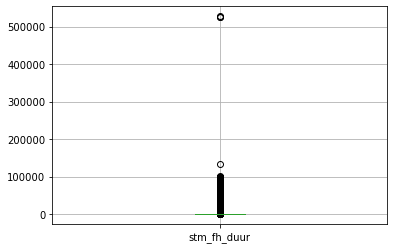

In [48]:
useful_data.boxplot(column=['stm_fh_duur'])

Dat ziet er niet goed uit. Nu de Extreem sterke uitschieters eruit halen

In [49]:
useful_data= useful_data.dropna(how = 'all') 
useful_data = useful_data.reset_index(drop=True)
Q1 = useful_data['stm_fh_duur'].quantile(0.25)
Q3 = useful_data['stm_fh_duur'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

221.0


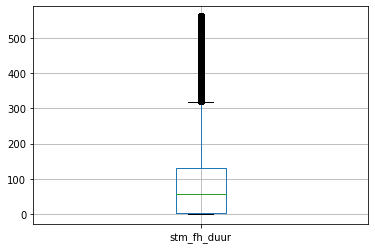

In [50]:
only_duur = useful_data['stm_fh_duur']
useful_data['strong_outlier'] = ((only_duur < (Q1 - 1.5 * IQR)) | (only_duur > (Q3 + 1.5 * IQR))) #create temporary column
useful_data = useful_data.drop(useful_data[useful_data.strong_outlier == True].index)

useful_data =  useful_data.drop('strong_outlier', 1)

useful_data.boxplot(column=['stm_fh_duur'])

Een reparatietijd van 0 minuten kan natuurlijk niet. Laten we kijken hoeveel meldingen ook zo'n lage reparatietijd heeft

In [51]:
countings = pd.DataFrame(useful_data['stm_fh_duur'].value_counts())
countings = countings.reset_index()
countings = countings.sort_values(by=['index'])
countings

index  stm_fh_duur
0      0.0       109244
63     1.0         1886
13     2.0         2407
2      3.0         4233
5      4.0         3777
..     ...          ...
556  558.0           63
559  559.0           59
521  560.0           75
560  561.0           59
555  562.0           64

[563 rows x 2 columns]

Een melding die 3 minuten duurt, hoef geen aannemer wordeng gebeld. Laten we die rijen verwijderen

In [52]:
useful_data = useful_data.drop(useful_data[useful_data.stm_fh_duur < 4].index)
useful_data

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
0                     0          NaN            NaN         NaN   
2              50053213         51.0          143.0         201   
3              50053214         40.0          142.0          25   
4              50053215          6.0          142.0          12   
5              50053218          7.0          218.0         614   
...                 ...          ...            ...         ...   
566474         99003501         63.0          215.0         104   
566477         99003504         25.0          298.0         158   
566478         99003505         83.0          215.0         NaN   
566479         99003506         83.0          218.0         468   
566480         99999999         19.0          135.0         102   

           stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  
0                       NaN             NaN            NaN  
2       02/01/2006 12:35:00             9.0       ONR-DERD  
3       02/01/2006 16:40:00             9.0       ONR-DERD  
4       02/01/2006 22:30:00             9.0       ONR-DERD  
5       02/01/2006 11:23:00             9.0        TECHONV  
...                     ...             ...            ...  
566474  11/05/2013 06:44:00             2.0        TECHONV  
566477  11/05/2013 07:59:00             5.0        TECHONV  
566478  11/05/2013 08:06:00             5.0        TECHONV  
566479  11/05/2013 09:21:00             2.0        TECHONV  
566480  20/08/2016 14:15:17             2.0        ONR-RIB  

[359970 rows x 7 columns]

Na al deze bewerkingen kloppen natuurlijk de indexes niet meer dus die worden gereset

In [53]:
useful_data= useful_data.dropna(how = 'all') 
useful_data = useful_data.reset_index(drop=True)
useful_data

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
0                     0          NaN            NaN         NaN   
1              50053213         51.0          143.0         201   
2              50053214         40.0          142.0          25   
3              50053215          6.0          142.0          12   
4              50053218          7.0          218.0         614   
...                 ...          ...            ...         ...   
359965         99003501         63.0          215.0         104   
359966         99003504         25.0          298.0         158   
359967         99003505         83.0          215.0         NaN   
359968         99003506         83.0          218.0         468   
359969         99999999         19.0          135.0         102   

           stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  
0                       NaN             NaN            NaN  
1       02/01/2006 12:35:00             9.0       ONR-DERD  
2       02/01/2006 16:40:00             9.0       ONR-DERD  
3       02/01/2006 22:30:00             9.0       ONR-DERD  
4       02/01/2006 11:23:00             9.0        TECHONV  
...                     ...             ...            ...  
359965  11/05/2013 06:44:00             2.0        TECHONV  
359966  11/05/2013 07:59:00             5.0        TECHONV  
359967  11/05/2013 08:06:00             5.0        TECHONV  
359968  11/05/2013 09:21:00             2.0        TECHONV  
359969  20/08/2016 14:15:17             2.0        ONR-RIB  

[359970 rows x 7 columns]

Daarna kan je dan de onbekende (nans) verwijderen om ValueErrors te voorkomen. Toch kunnen we later met maar een aantal kolommen toch te werk gaan. Dus maken we een nieuwe dataframe die Nan proof is voor later

In [54]:
useful_data.isna().sum()

#stm_sap_meldnr         0
stm_fh_duur            19
stm_oorz_code       10062
stm_geo_gst         69993
stm_sap_meld_ddt        1
stm_prioriteit         45
stm_oorz_groep      10062
dtype: int64

In [55]:
useful_data_Nan_proof = useful_data.dropna()
useful_data_Nan_proof = useful_data_Nan_proof.reset_index(drop=True)
useful_data_Nan_proof

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
0              50053213         51.0          143.0         201   
1              50053214         40.0          142.0          25   
2              50053215          6.0          142.0          12   
3              50053218          7.0          218.0         614   
4              50053219         13.0          142.0         551   
...                 ...          ...            ...         ...   
282753         99003495        122.0          212.0         924   
282754         99003501         63.0          215.0         104   
282755         99003504         25.0          298.0         158   
282756         99003506         83.0          218.0         468   
282757         99999999         19.0          135.0         102   

           stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  
0       02/01/2006 12:35:00             9.0       ONR-DERD  
1       02/01/2006 16:40:00             9.0       ONR-DERD  
2       02/01/2006 22:30:00             9.0       ONR-DERD  
3       02/01/2006 11:23:00             9.0        TECHONV  
4       02/01/2006 23:25:00             9.0       ONR-DERD  
...                     ...             ...            ...  
282753  10/05/2013 21:44:00             2.0        TECHONV  
282754  11/05/2013 06:44:00             2.0        TECHONV  
282755  11/05/2013 07:59:00             5.0        TECHONV  
282756  11/05/2013 09:21:00             2.0        TECHONV  
282757  20/08/2016 14:15:17             2.0        ONR-RIB  

[282758 rows x 7 columns]

Om later natuurlijk makkelijker te werken met de dates moet de type omgezet worden naar datetime. In dit geval alleen voor'stm_sap_meld_ddt'

In [56]:
useful_data['stm_sap_meld_ddt'] = pd.to_datetime(useful_data['stm_sap_meld_ddt'])
useful_data.dtypes

#stm_sap_meldnr              int64
stm_fh_duur                float64
stm_oorz_code              float64
stm_geo_gst                 object
stm_sap_meld_ddt    datetime64[ns]
stm_prioriteit             float64
stm_oorz_groep              object
dtype: object

In [57]:
# df.isnull().sum()

TADA, de perfecte dataset

### Data preparation

In [58]:
useful_data_Nan_proof['stm_fh_duur'].mean()

123.7249273230112

In [59]:
pd.DataFrame(useful_data_Nan_proof['stm_fh_duur'].value_counts())

stm_fh_duur
5.0           3590
6.0           2722
7.0           2605
4.0           2565
8.0           2454
...            ...
558.0           48
562.0           47
559.0           42
548.0           41
546.0           38

[559 rows x 1 columns]

Om te kijken welke kolommen een verband (correlatie) met elkaar hebben, gaan we describe gebruiken

In [60]:
useful_data.corr()

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code  stm_prioriteit
#stm_sap_meldnr         1.000000     0.002454       0.081805       -0.111189
stm_fh_duur             0.002454     1.000000      -0.089121        0.177653
stm_oorz_code           0.081805    -0.089121       1.000000        0.030488
stm_prioriteit         -0.111189     0.177653       0.030488        1.000000

In [61]:
useful_data.describe()

#stm_sap_meldnr    stm_fh_duur  stm_oorz_code  stm_prioriteit
count     3.599700e+05  359951.000000  349908.000000   359925.000000
mean      7.980314e+07     121.790652     202.851852        3.574720
std       3.642236e+06     113.755766      48.462754        1.496199
min       0.000000e+00       4.000000      33.000000        1.000000
25%       8.044922e+07      42.000000     151.000000        2.000000
50%       8.059760e+07      87.000000     215.000000        4.000000
75%       8.074434e+07     163.000000     221.000000        5.000000
max       1.000000e+08     562.000000     999.000000        9.000000

### Sprint 1 baseline model code:

### Baseline model gemaakt zonder cleaning
boxplot om te kijken hoe ver data van elkaar ligt

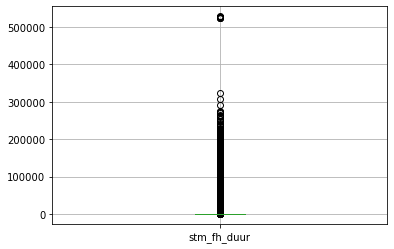

In [62]:
oplostijd_data = oplostijd_data.dropna()
oplostijd_data.boxplot(column=['stm_fh_duur'])

Gemiddelde wordt berekent en als kolom toegevoegd

In [63]:
gemiddelde_oplostijd = oplostijd_data['stm_fh_duur'].mean()
gemiddelde_oplostijd = round(float(str(gemiddelde_oplostijd)[15:25]))
print("Gemiddelde: " + str(gemiddelde_oplostijd) + " minuten")
oplostijd_data['gemiddelde'] = gemiddelde_oplostijd
oplostijd_data.describe()

Gemiddelde: 92 minuten


stm_fh_duur  gemiddelde  close_to_mean
count  898488.000000    898488.0  898488.000000
mean      923.148771        92.0     831.148771
std      6404.546787         0.0    6404.546787
min         0.000000        92.0     -92.000000
25%        11.000000        92.0     -81.000000
50%        84.000000        92.0      -8.000000
75%       256.000000        92.0     164.000000
max    528297.000000        92.0  528205.000000

Nan's worden gedropt en "hoe ver van gemiddelde af" kolom


In [64]:

oplostijd_data['close_to_mean'] = oplostijd_data['stm_fh_duur'] - gemiddelde_oplostijd
oplostijd_data

stm_fh_duur  gemiddelde  close_to_mean
1               0.0          92          -92.0
2              51.0          92          -41.0
3              40.0          92          -52.0
4               6.0          92          -86.0
5               7.0          92          -85.0
...             ...         ...            ...
898521         83.0          92           -9.0
898522         83.0          92           -9.0
898523         83.0          92           -9.0
898524         19.0          92          -73.0
898525         19.0          92          -73.0

[898488 rows x 3 columns]

In [65]:
# source: https://stackoverflow.com/questions/30112202/how-do-i-find-the-closest-values-in-a-pandas-series-to-an-input-number
closest_mean_data = oplostijd_data.iloc[(oplostijd_data['close_to_mean']- 0).abs().argsort()]
closest_mean_data

stm_fh_duur  gemiddelde  close_to_mean
524494         92.0          92            0.0
577345         92.0          92            0.0
814239         92.0          92            0.0
577346         92.0          92            0.0
466180         92.0          92            0.0
...             ...         ...            ...
588865     525696.0          92       525604.0
588864     525696.0          92       525604.0
732303     527176.0          92       527084.0
732304     527176.0          92       527084.0
670693     528297.0          92       528205.0

[898488 rows x 3 columns]

### error scores
##### - accuracy
##### - r2
##### - mean square

In [66]:
on_mean_times = closest_mean_data[closest_mean_data.close_to_mean == 0].shape[0]
# print("{} waardes zijn gelijk aan het gemiddelde, {} is het aantal waardes dus {}% van de waardes is gelijk aan de gemiddelde reparatietijd".format(on_mean_times, len(closest_mean_data), on_mean_times/len(closest_mean_data)*100))
print("{} waardes gelijk aan gemiddelde , {} totaal waardes & {}% gelijk aan de gemiddelde reparatietijd".format(on_mean_times, len(closest_mean_data), on_mean_times/len(closest_mean_data)*100))

2628 waardes gelijk aan gemiddelde , 898488 totaal waardes & 0.29249138552768655% gelijk aan de gemiddelde reparatietijd


In [67]:
r2_uncleaned = r2_score(closest_mean_data['gemiddelde'], closest_mean_data['stm_fh_duur'])
r2_uncleaned

0.0

In [68]:
sq_error_uncleaned = mean_squared_error(closest_mean_data['gemiddelde'], closest_mean_data['stm_fh_duur'], squared=False)
sq_error_uncleaned

6458.249157358097

### Baseline model gemaakt met cleaning
Boxplot was gedaan om te kijken hoe ver de data van elkaar ligt

In [69]:
useful_data_mean = useful_data.dropna(subset=['stm_fh_duur'])
useful_data_mean

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
1              50053213         51.0          143.0         201   
2              50053214         40.0          142.0          25   
3              50053215          6.0          142.0          12   
4              50053218          7.0          218.0         614   
5              50053219         13.0          142.0         551   
...                 ...          ...            ...         ...   
359965         99003501         63.0          215.0         104   
359966         99003504         25.0          298.0         158   
359967         99003505         83.0          215.0         NaN   
359968         99003506         83.0          218.0         468   
359969         99999999         19.0          135.0         102   

          stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  
1      2006-02-01 12:35:00             9.0       ONR-DERD  
2      2006-02-01 16:40:00             9.0       ONR-DERD  
3      2006-02-01 22:30:00             9.0       ONR-DERD  
4      2006-02-01 11:23:00             9.0        TECHONV  
5      2006-02-01 23:25:00             9.0       ONR-DERD  
...                    ...             ...            ...  
359965 2013-11-05 06:44:00             2.0        TECHONV  
359966 2013-11-05 07:59:00             5.0        TECHONV  
359967 2013-11-05 08:06:00             5.0        TECHONV  
359968 2013-11-05 09:21:00             2.0        TECHONV  
359969 2016-08-20 14:15:17             2.0        ONR-RIB  

[359951 rows x 7 columns]

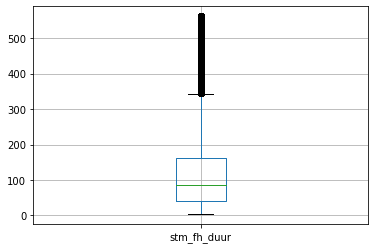

In [70]:

useful_data_mean.boxplot(column=['stm_fh_duur'])

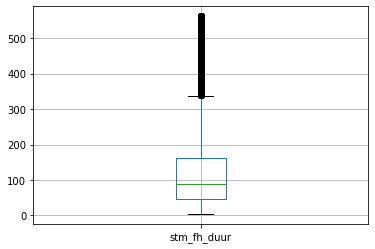

In [71]:
useful_data_Nan_proof.boxplot(column=['stm_fh_duur'])

In [72]:
useful_data_mean

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
1              50053213         51.0          143.0         201   
2              50053214         40.0          142.0          25   
3              50053215          6.0          142.0          12   
4              50053218          7.0          218.0         614   
5              50053219         13.0          142.0         551   
...                 ...          ...            ...         ...   
359965         99003501         63.0          215.0         104   
359966         99003504         25.0          298.0         158   
359967         99003505         83.0          215.0         NaN   
359968         99003506         83.0          218.0         468   
359969         99999999         19.0          135.0         102   

          stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  
1      2006-02-01 12:35:00             9.0       ONR-DERD  
2      2006-02-01 16:40:00             9.0       ONR-DERD  
3      2006-02-01 22:30:00             9.0       ONR-DERD  
4      2006-02-01 11:23:00             9.0        TECHONV  
5      2006-02-01 23:25:00             9.0       ONR-DERD  
...                    ...             ...            ...  
359965 2013-11-05 06:44:00             2.0        TECHONV  
359966 2013-11-05 07:59:00             5.0        TECHONV  
359967 2013-11-05 08:06:00             5.0        TECHONV  
359968 2013-11-05 09:21:00             2.0        TECHONV  
359969 2016-08-20 14:15:17             2.0        ONR-RIB  

[359951 rows x 7 columns]

Gemiddelde wordt berekent en als kolom toegevoegd

In [73]:
gemiddelde_oplostijd = useful_data_mean['stm_fh_duur'].mean()
gemiddelde_oplostijd = round(float(str(gemiddelde_oplostijd)))
print("Gemiddelde: " + str(gemiddelde_oplostijd) + " minuten")
useful_data_mean['gemiddelde'] = gemiddelde_oplostijd
useful_data_mean


Gemiddelde: 122 minuten


d:\users\ruben\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
1              50053213         51.0          143.0         201   
2              50053214         40.0          142.0          25   
3              50053215          6.0          142.0          12   
4              50053218          7.0          218.0         614   
5              50053219         13.0          142.0         551   
...                 ...          ...            ...         ...   
359965         99003501         63.0          215.0         104   
359966         99003504         25.0          298.0         158   
359967         99003505         83.0          215.0         NaN   
359968         99003506         83.0          218.0         468   
359969         99999999         19.0          135.0         102   

          stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  gemiddelde  
1      2006-02-01 12:35:00             9.0       ONR-DERD         122  
2      2006-02-01 16:40:00             9.0       ONR-DERD         122  
3      2006-02-01 22:30:00             9.0       ONR-DERD         122  
4      2006-02-01 11:23:00             9.0        TECHONV         122  
5      2006-02-01 23:25:00             9.0       ONR-DERD         122  
...                    ...             ...            ...         ...  
359965 2013-11-05 06:44:00             2.0        TECHONV         122  
359966 2013-11-05 07:59:00             5.0        TECHONV         122  
359967 2013-11-05 08:06:00             5.0        TECHONV         122  
359968 2013-11-05 09:21:00             2.0        TECHONV         122  
359969 2016-08-20 14:15:17             2.0        ONR-RIB         122  

[359951 rows x 8 columns]

In [74]:
useful_data_mean['close_to_mean'] = useful_data_mean['stm_fh_duur'] - gemiddelde_oplostijd
useful_data_mean

d:\users\ruben\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
1              50053213         51.0          143.0         201   
2              50053214         40.0          142.0          25   
3              50053215          6.0          142.0          12   
4              50053218          7.0          218.0         614   
5              50053219         13.0          142.0         551   
...                 ...          ...            ...         ...   
359965         99003501         63.0          215.0         104   
359966         99003504         25.0          298.0         158   
359967         99003505         83.0          215.0         NaN   
359968         99003506         83.0          218.0         468   
359969         99999999         19.0          135.0         102   

          stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  gemiddelde  \
1      2006-02-01 12:35:00             9.0       ONR-DERD         122   
2      2006-02-01 16:40:00             9.0       ONR-DERD         122   
3      2006-02-01 22:30:00             9.0       ONR-DERD         122   
4      2006-02-01 11:23:00             9.0        TECHONV         122   
5      2006-02-01 23:25:00             9.0       ONR-DERD         122   
...                    ...             ...            ...         ...   
359965 2013-11-05 06:44:00             2.0        TECHONV         122   
359966 2013-11-05 07:59:00             5.0        TECHONV         122   
359967 2013-11-05 08:06:00             5.0        TECHONV         122   
359968 2013-11-05 09:21:00             2.0        TECHONV         122   
359969 2016-08-20 14:15:17             2.0        ONR-RIB         122   

        close_to_mean  
1               -71.0  
2               -82.0  
3              -116.0  
4              -115.0  
5              -109.0  
...               ...  
359965          -59.0  
359966          -97.0  
359967          -39.0  
359968          -39.0  
359969         -103.0  

[359951 rows x 9 columns]

In [75]:
useful_data_mean = useful_data_mean.sort_values(by='close_to_mean', ascending=False)
useful_data_mean

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
303423         80806965        562.0          143.0         NaN   
299853         80800203        562.0          143.0          83   
28106          80347081        562.0          212.0         950   
88837          80447261        562.0          294.0         NaN   
334628         80869057        562.0          151.0         123   
...                 ...          ...            ...         ...   
159434         80565024          4.0          294.0         520   
301962         80804171          4.0          218.0         NaN   
166397         80576341          4.0          207.0         117   
230767         80679187          4.0          151.0          35   
325935         80851623          4.0          221.0         531   

          stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  gemiddelde  \
303423 2015-05-26 06:17:00             5.0       ONR-DERD         122   
299853 2015-03-22 00:09:00             5.0       ONR-DERD         122   
28106  2006-02-02 00:35:09             5.0        TECHONV         122   
88837  2008-10-03 01:50:00             5.0        TECHONV         122   
334628 2016-06-11 05:03:49             5.0       ONR-DERD         122   
...                    ...             ...            ...         ...   
159434 2010-06-26 00:05:00             4.0        TECHONV         122   
301962 2015-04-27 17:51:00             4.0        TECHONV         122   
166397 2010-04-09 19:22:00             2.0        TECHONV         122   
230767 2012-10-08 11:10:00             5.0       ONR-DERD         122   
325935 2016-06-13 16:25:11             4.0        TECHONV         122   

        close_to_mean  
303423          440.0  
299853          440.0  
28106           440.0  
88837           440.0  
334628          440.0  
...               ...  
159434         -118.0  
301962         -118.0  
166397         -118.0  
230767         -118.0  
325935         -118.0  

[359951 rows x 9 columns]

In [76]:
closest_mean_data = useful_data_mean.iloc[(useful_data_mean['close_to_mean']- 0).abs().argsort()]
closest_mean_data

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
49992          80383718        122.0          189.0         NaN   
293641         80788311        122.0          149.0         NaN   
189625         80613170        122.0          151.0           6   
166437         80576412        122.0          133.0          76   
251380         80712941        122.0          133.0         112   
...                 ...          ...            ...         ...   
201326         80632173        562.0          215.0         624   
155630         80558671        562.0          218.0         506   
281092         80765053        562.0          135.0         NaN   
102752         80470412        562.0          226.0         542   
303423         80806965        562.0          143.0         NaN   

          stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  gemiddelde  \
49992  2006-11-16 00:01:00             2.0           WEER         122   
293641 2014-02-12 07:53:00             2.0       ONR-DERD         122   
189625 2011-04-28 10:56:00             5.0       ONR-DERD         122   
166437 2010-05-09 16:21:00             2.0        ONR-RIB         122   
251380 2013-01-04 02:25:00             2.0        ONR-RIB         122   
...                    ...             ...            ...         ...   
201326 2011-10-09 00:36:00             5.0        TECHONV         122   
155630 2010-05-14 00:36:00             5.0        TECHONV         122   
281092 2014-05-18 15:08:00             5.0        ONR-RIB         122   
102752 2008-08-27 23:49:00             5.0        TECHONV         122   
303423 2015-05-26 06:17:00             5.0       ONR-DERD         122   

        close_to_mean  
49992             0.0  
293641            0.0  
189625            0.0  
166437            0.0  
251380            0.0  
...               ...  
201326          440.0  
155630          440.0  
281092          440.0  
102752          440.0  
303423          440.0  

[359951 rows x 9 columns]

### error scores
##### - accuracy
##### - r2
##### - mean square

In [77]:
on_mean_times = closest_mean_data[closest_mean_data.close_to_mean == 0].shape[0]
# print("{} waardes zijn gelijk aan het gemiddelde, {} is het aantal waardes dus {}% van de waardes is gelijk aan de gemiddelde reparatietijd".format(on_mean_times, len(closest_mean_data), on_mean_times/len(closest_mean_data)*100))
print("{} waardes gelijk aan gemiddelde , {} totaal waardes & {}% gelijk aan de gemiddelde reparatietijd".format(on_mean_times, len(closest_mean_data), on_mean_times/len(closest_mean_data)*100))

1198 waardes gelijk aan gemiddelde , 359951 totaal waardes & 0.33282307869682265% gelijk aan de gemiddelde reparatietijd


In [78]:
r2_cleaned = r2_score(closest_mean_data['gemiddelde'], closest_mean_data['stm_fh_duur'])
r2_cleaned


0.0

In [79]:
sq_error_cleaned = mean_squared_error(closest_mean_data['gemiddelde'], closest_mean_data['stm_fh_duur'], squared=False)
sq_error_cleaned

113.7558006302032

#### Features testing

In [82]:
feature_test_data = useful_data[['stm_fh_duur', 'stm_prioriteit', 'stm_oorz_groep']]

In [84]:
useful_data

#stm_sap_meldnr  stm_fh_duur  stm_oorz_code stm_geo_gst  \
0                     0          NaN            NaN         NaN   
1              50053213         51.0          143.0         201   
2              50053214         40.0          142.0          25   
3              50053215          6.0          142.0          12   
4              50053218          7.0          218.0         614   
...                 ...          ...            ...         ...   
359965         99003501         63.0          215.0         104   
359966         99003504         25.0          298.0         158   
359967         99003505         83.0          215.0         NaN   
359968         99003506         83.0          218.0         468   
359969         99999999         19.0          135.0         102   

          stm_sap_meld_ddt  stm_prioriteit stm_oorz_groep  
0                      NaT             NaN            NaN  
1      2006-02-01 12:35:00             9.0       ONR-DERD  
2      2006-02-01 16:40:00             9.0       ONR-DERD  
3      2006-02-01 22:30:00             9.0       ONR-DERD  
4      2006-02-01 11:23:00             9.0        TECHONV  
...                    ...             ...            ...  
359965 2013-11-05 06:44:00             2.0        TECHONV  
359966 2013-11-05 07:59:00             5.0        TECHONV  
359967 2013-11-05 08:06:00             5.0        TECHONV  
359968 2013-11-05 09:21:00             2.0        TECHONV  
359969 2016-08-20 14:15:17             2.0        ONR-RIB  

[359970 rows x 7 columns]

In [85]:
feature_test_data

stm_fh_duur  stm_prioriteit stm_oorz_groep
0               NaN             NaN            NaN
1              51.0             9.0       ONR-DERD
2              40.0             9.0       ONR-DERD
3               6.0             9.0       ONR-DERD
4               7.0             9.0        TECHONV
...             ...             ...            ...
359965         63.0             2.0        TECHONV
359966         25.0             5.0        TECHONV
359967         83.0             5.0        TECHONV
359968         83.0             2.0        TECHONV
359969         19.0             2.0        ONR-RIB

[359970 rows x 3 columns]

In [117]:
feature_test_data.dtypes

stm_fh_duur       float64
stm_prioriteit    float64
stm_oorz_groep     object
dtype: object

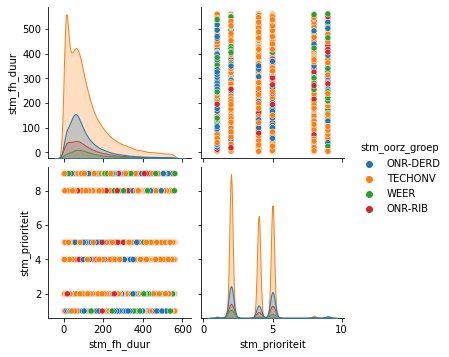

In [120]:
sns.pairplot(feature_test_data,hue='stm_oorz_groep')

In [137]:
feature_test_data = feature_test_data.dropna()
feature_test_data.corr()

stm_fh_duur  stm_prioriteit
stm_fh_duur        1.000000        0.182618
stm_prioriteit     0.182618        1.000000

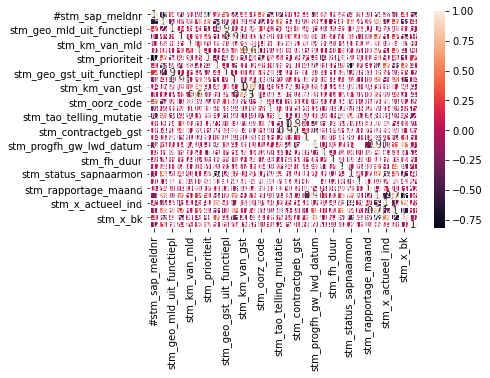

In [226]:
sns.heatmap(read_data.corr(),annot=True,lw=1)

In [177]:
#source https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    try:
        au_corr = df.corr().abs().unstack()
        labels_to_drop = get_redundant_pairs(df)
        au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
        
    except KeyError:
        pass
    return au_corr[0:n]
    

read_data
print(get_top_abs_correlations(read_data, 20))

#stm_sap_meldnr  #stm_sap_meldnr              1.000000
                 stm_mon_nr                   0.561259
                 stm_geo_mld_uit_functiepl    0.224076
                 stm_equipm_nr_mld            0.203350
                 stm_km_van_mld               0.007434
                 stm_km_tot_mld               0.097676
                 stm_prioriteit               0.716977
                 stm_mon_nr__statuscode       0.154912
                 stm_geo_gst_uit_functiepl    0.218851
                 stm_equipm_nr_gst            0.242909
                 stm_km_van_gst               0.046235
                 stm_km_tot_gst               0.010300
                 stm_oorz_code                0.353319
                 stm_fh_status                0.217210
                 stm_tao_telling_mutatie      0.300278
                 stm_contractgeb_mld          0.068555
                 stm_contractgeb_gst          0.084121
                 stm_arbeid                   0.041034
          

In [192]:
corr = read_data.corr() # df is the pandas dataframe
c1 = corr.abs().unstack()
highest_corr = (pd.DataFrame(c1.sort_values(ascending = False))).reset_index()
highest_corr = highest_corr.loc[highest_corr['level_0'] == 'stm_fh_duur']
highest_corr

level_0                    level_1         0
8    stm_fh_duur                stm_fh_duur  1.000000
340  stm_fh_duur                 stm_arbeid  0.076406
391  stm_fh_duur            #stm_sap_meldnr  0.065408
411  stm_fh_duur                 stm_mon_nr  0.059769
484  stm_fh_duur    stm_tao_telling_mutatie  0.040127
548  stm_fh_duur              stm_oorz_code  0.028632
559  stm_fh_duur          stm_x_actueel_ind  0.023105
560  stm_fh_duur  stm_geo_mld_uit_functiepl  0.023062
566  stm_fh_duur       stm_progfh_gw_teller  0.022379
577  stm_fh_duur      stm_status_sapnaarmon  0.021359
579  stm_fh_duur  stm_geo_gst_uit_functiepl  0.021116
602  stm_fh_duur             stm_km_tot_gst  0.017142
606  stm_fh_duur        stm_x_vervallen_ind  0.016500
623  stm_fh_duur             stm_km_tot_mld  0.015090
625  stm_fh_duur     stm_mon_nr__statuscode  0.014891
634  stm_fh_duur             stm_km_van_gst  0.014012
655  stm_fh_duur        stm_contractgeb_gst  0.012619
658  stm_fh_duur             stm_km_van_mld  0.011923
730  stm_fh_duur          stm_equipm_nr_mld  0.007824
739  stm_fh_duur        stm_rapportage_jaar  0.007671
740  stm_fh_duur          stm_equipm_nr_gst  0.007632
745  stm_fh_duur              stm_fh_status  0.007453
755  stm_fh_duur             stm_prioriteit  0.006820
758  stm_fh_duur        stm_contractgeb_mld  0.006723
766  stm_fh_duur                   stm_x_bk  0.006135
803  stm_fh_duur               stm_x_run_id  0.003208
815  stm_fh_duur       stm_rapportage_maand  0.002616
817  stm_fh_duur    stm_progfh_gw_lwd_datum  0.002555
851  stm_fh_duur           stm_reactie_duur  0.001232
878  stm_fh_duur               stm_schadenr  0.000327

In [198]:
featuredata1 = read_data[['stm_fh_duur', 'stm_tao_telling_mutatie', 'stm_mon_nr']]
featuredata1

stm_fh_duur  stm_tao_telling_mutatie  stm_mon_nr
1               0.0                        0         0.0
2              51.0                        0        48.0
3              40.0                        0        72.0
4               6.0                        0        96.0
5               7.0                        0        38.0
...             ...                      ...         ...
898521         83.0                        0         0.0
898522         83.0                        0         0.0
898523         83.0                        0         0.0
898524         19.0                        0         0.0
898525         19.0                        0         0.0

[898488 rows x 3 columns]

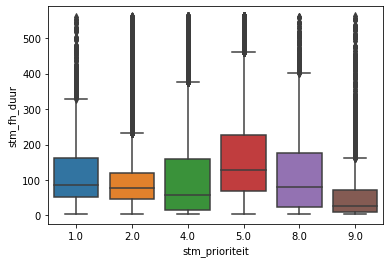

In [202]:
sns.boxplot(y='stm_fh_duur',x='stm_prioriteit',data=feature_test_data)

In [216]:
DummiesX = pd.get_dummies(data=feature_test_data[['stm_oorz_groep']])
DummiesX.head()

stm_oorz_groep_ONR-DERD  stm_oorz_groep_ONR-RIB  stm_oorz_groep_TECHONV  \
1                        1                       0                       0   
2                        1                       0                       0   
3                        1                       0                       0   
4                        0                       0                       1   
5                        1                       0                       0   

   stm_oorz_groep_WEER  
1                    0  
2                    0  
3                    0  
4                    0  
5                    0

In [217]:
DummiesY = featuredata1[['stm_fh_duur']]
# DummiesY = DummiesY.dropna()
DummiesY

stm_fh_duur
1               0.0
2              51.0
3              40.0
4               6.0
5               7.0
...             ...
898521         83.0
898522         83.0
898523         83.0
898524         19.0
898525         19.0

[898488 rows x 1 columns]

In [218]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DummiesX, DummiesY, test_size=0.4, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

ValueError: Found input variables with inconsistent numbers of samples: [349890, 898488]

In [219]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [220]:
print(model.intercept_)

[8.91197792e+11]


In [221]:
predictions = model.predict(X_test)
predictions

array([[127.39953613],
       [127.39953613],
       [141.49963379],
       ...,
       [ 93.71777344],
       [136.01794434],
       [133.52380371]])

d:\users\ruben\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


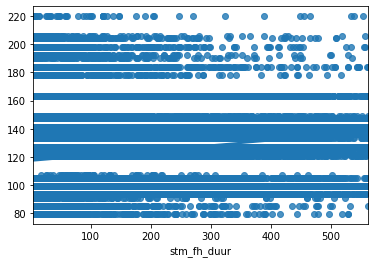

In [222]:
sns.regplot(y_test,predictions)

In [223]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:            stm_fh_duur   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1548.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:20:47   Log-Likelihood:            -1.2872e+06
No. Observations:              209934   AIC:                         2.574e+06
Df Residuals:                  209928   BIC:                         2.575e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

In [224]:
r2_score(y_test,predictions)

0.03647043293483565

In [225]:
mean_squared_error(y_test, predictions, squared=False)

111.20188261332888